In [66]:
from qiskit import QuantumCircuit, transpile
import numpy as np
from qiskit.visualization import *
import matplotlib.pyplot as plt
import math
from itertools import repeat
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from math import pi
from qiskit.primitives import Sampler as PrimitiveSampler
from qiskit_ibm_runtime import Session, Sampler, Options

from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='f219a915892b0bd40aa07d0a9ff142343fc9ca52a0072fe521f6596e4abfc19bd155e6d6b25c70c31d7f9dbe960ac57e40e305da34c7a086343f21e54df3779f'
)

# Or save your credentials on disk.
# QiskitRuntimeService.save_account(channel='ibm_quantum', instance='ibm-q/open/main', token='75b64d61bf2f383a554327210c3992abd77f402c9c12e77094d6da090094390c0ddcdc4ae9531cf2079d04ee9fb318685f2300291fbb5bc1aa6f6bf4942250eb')


s1=[]
s2=[]
s3=[]
s4=[]
ts=[]
d1=[]
d2=[]
d3=[]
d4=[]
C=[]
C_AB=[]
dC_AB=[]
dC=[]
paso=5

backend = service.get_backend("ibm_brisbane")
#backend = service.get_backend("ibmq_qasm_simulator")

In [37]:
def build_circuit(p, theta, zne):
    
    alfa=2*np.arccos(np.sqrt(3*p/4))
    beta=2*np.arccos(np.sqrt(1/3))
    
    q=QuantumCircuit(16,2) 
    q.ry(np.pi-alfa,5)
    q.cry(beta,5,4)
    q.x(5)
    q.cry(-np.pi/2,4,5)
    q.x(4)
    q.cx(4,15)
    q.cry(np.pi-2*theta,15,3)
    q.cx(5,4)
    q.cx(5,3)
    q.cz(4,3)
    q.cx(3,15)
    q.h(3)
    q.h(15)
    
    
    i = zne
    qf = q
    while i > 0:
        qf = qf.compose(q.inverse())
        qf = qf.compose(q)
        i -= 1

    qf.measure([3,15],[0,1]) 
    return qf

In [67]:
s_size = 25
c=s_size
N = 4000
angles = 5
zne_size = 4
p = 0.2
#0-3,  1-15,  2-4,   3-5

k=14
t=paso*k*np.pi/180
circuits = []

for i in range(zne_size):
    circuits.extend(repeat(build_circuit(p, t, i), s_size))

######################################################
# pm = generate_preset_pass_manager(backend=backend, optimization_level=0)
# isa_circuits = pm.run(circuits)

options = Options()
options.resilience_level = 0

# sampler = Sampler(backend, options=options)
sampler = PrimitiveSampler()
job = sampler.run(circuits, shots=N)
counts=job.result().quasi_dists

temp1=[]
temp2=[]
temp3=[]
temp4=[]

for i in range(4):
    for j in range(i*c,(i+1)*c):
        temp1.append(counts[j].binary_probabilities().get('00',0))
        temp2.append(counts[j].binary_probabilities().get('01',0))
        temp3.append(counts[j].binary_probabilities().get('10',0))
        temp4.append(counts[j].binary_probabilities().get('11',0))

    d1=np.std(temp1)
    d2=np.std(temp2)
    d3=np.std(temp3)
    d4=np.std(temp4)
    s1=sum(temp1)/c#pxh
    s2=sum(temp2)/c#pyh
    s3=sum(temp3)/c#pxv
    s4=sum(temp4)/c#pyv
    temp1=[]
    temp2=[]
    temp3=[]
    temp4=[] 
    C.append(np.abs(s1-s2+s3-s4))
    dC.append(np.sqrt(d1**2+d2**2+d3**2+d4**2))

#y=a*exp(b*x)   
#ln(y)=ln(a)+b*x   
#fit(1)=ln(a)
#fit(0)=b   
#ln(y)=fit(1)+fit(0)*x
    
dCp=([g1/g2 for g1,g2 in zip(dC,C)])
    
u=[1,3,5,7]
fit = np.polyfit(u, np.log(C), 1)
C_AB.append(np.exp(fit[1]))   
#######################  
s1d2=sum([1/g2**2 for g2 in dCp])
ud2=sum([g1/g2**2 for g1,g2 in zip(u,dCp)])
u2d2=sum([g1**2/g2**2 for g1,g2 in zip(u,dCp)])
D=s1d2*u2d2-ud2**2
#######################
dC_AB.append(np.sqrt(u2d2/D)*np.exp(fit[1]))    
dC=[]
C=[]
ts.append(paso*np.pi*k/180)

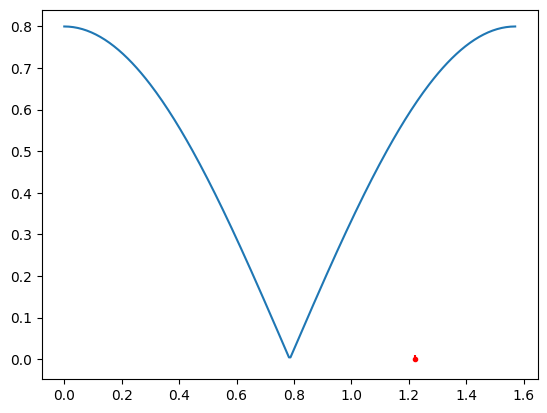

In [69]:
th = np.linspace(0, pi/2, 300,endpoint=True)
C = (1-p)*np.abs(np.cos(2*th))

plt.errorbar(ts, C_AB, dC_AB, fmt = 'r.')
plt.plot(th,C)

In [54]:
ts

[1.2217304763960306]

In [56]:
dC_AB

[0.06774327309119073]

In [1]:
#p=0.2
#0.08798817635346713-0.0886119265465953
#
#0.7876637267390927-0.08636684097454891
#
#

In [6]:
#p=0.6
#0.07229076064153807-0.07618929822446507
#0.17690021950565052-0.08351287392280468
#0.4340004428641485-0.07494212594338018 / 0.3558829098880565-0.0673826890891745
#0.18219128109229166-0.08338975922423349
#0.058888272695467314-0.049061604516996975

In [7]:
#p=0.4
#
#
#0.5394205030221598-0.014576783050019639
#
#

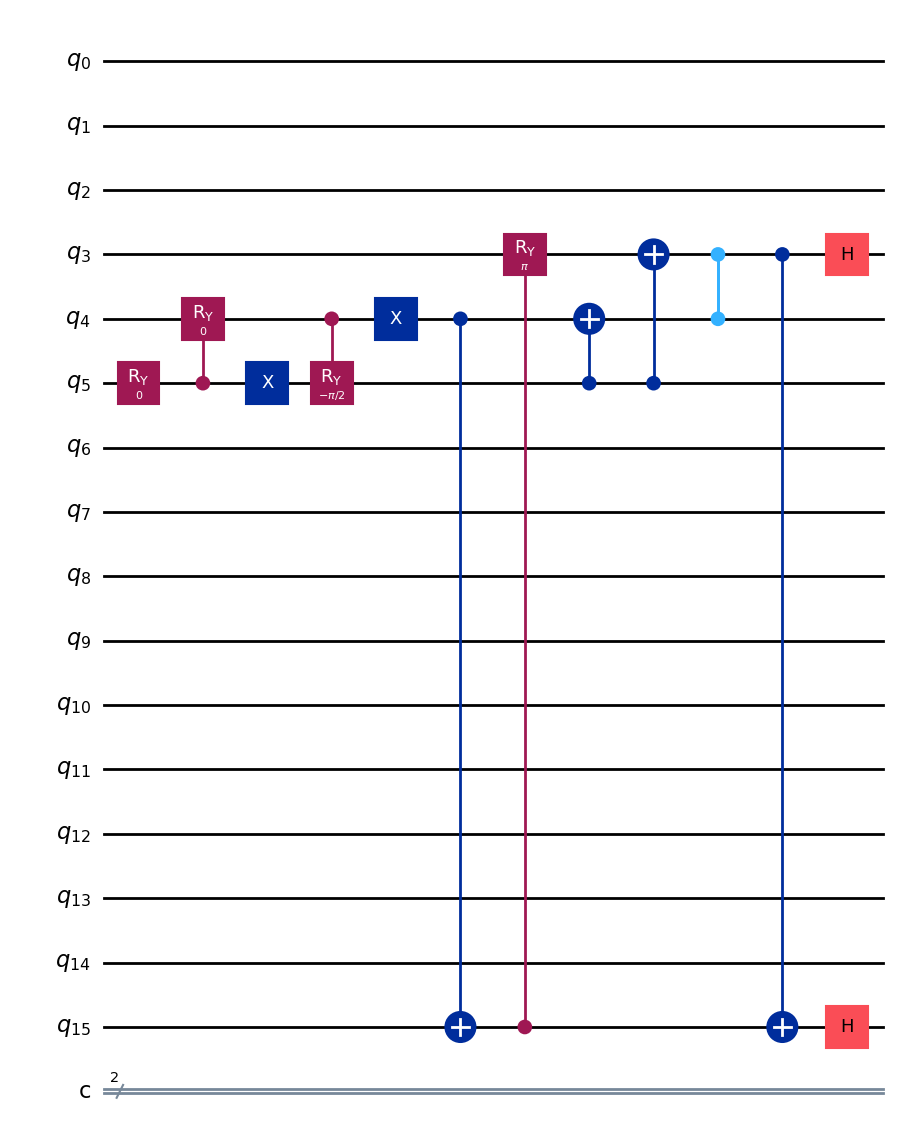

In [24]:
q=QuantumCircuit(16,2) 
q.ry(0,5)
q.cry(0,5,4)
q.x(5)
q.cry(-np.pi/2,4,5)
q.x(4)
q.cx(4,15)
q.cry(np.pi,15,3)
q.cx(5,4)
q.cx(5,3)
q.cz(4,3)
q.cx(3,15)
q.h(3)
q.h(15)
q.draw('mpl')